Neural Network is flexible to describe various nonlinear functions as known in [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem). It is, however, difficult to figure out what part of input has significant effect on the prediction. For example, if you classify a image to 'Cat', you make a decision after looking at whiskers, eyes, round face, etc. It is difficult to understand the reason why your Neural Network model make this kind of reasoning, which avoids some industry from using Neural Network. 

The paper, [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf), introduces a method called `Integrated Gradient` to shed light on this aspect. This method evaluate how much each input feature contributes to the model output, i.e. input attribution. It is theoretically sound and easy to implement. Let's look at the detail!


# Theory

### Sensitivity and Implementation Invariance
When considering attributions of an input for a prediction, two axioms, `Sensitivity` and `Implementation Invariance`, are usually considered. 

Consider a benchmark $\hat{x}$ and an input $x$. 
`Sensitivity` refers to how attribution reflects difference in the input and output.
More precisely, when only one feature differs between the benchmark and the input, its attribution has to be non-zero. 

`Implementation Invariance` describes independence of attribution methods from how to implement models. For example, you can implement exactly the same generative model with different number of parameters by introducing marginalization techniques. If a method holds `Implementation Invariance`, attributions have to be independent of the number of parameters. 

As one of the examples to hold this property, you can consider the method which solely depends on derivatives because of the chain rule.


### Integrated Gradient
The idea behind `Integrated Gradient` is the property that a line integral does not depend on its path if the integrand is [totally differentiable](https://en.wikipedia.org/wiki/Total_derivative). Practically speaking, we can assume that most of neural network satisfies this property.

Mathematically speaking, `Integrated Gradient` is defined as
$$IntegratedGrads_i(x) = (x_i - \hat{x}_i) \times \int_{\alpha = 0}^1 \partial_i F(\hat{x} + \alpha (x - \hat{x})) d\alpha$$
for each coordination $i$.

This equation is derived through line integral. Consider the following identity
$$F(x) - F(x_0) = \int_{x_0}^x ds \cdot \nabla F(s)$$
$$= \sum_{i=1}^n \int_{x_0}^x ds_i \partial_i F(s)$$

`Integrated Gradient` can be considered as contribution of the line integral for each coordinate. 

Let's assume that your network model is totally differentiable. Then, the line integral is independent of its path and `Integrated Gradient` satisfies `Sensitivity`. 

From the construction based on derivatives, we also deduce that `Integrated Gradient` satisfies `Implementation Invariance`. Thus, `Integrated Gradient` satisfies both axioms.

`Integrated Gradient` holds other properties, e.g., `Symmetry-Preserving`. Please refer to the original paper. 


# Implementation
When implementing `Integrated Gradient`, the integral part is approximated with discretization,
$$IntegratedGrads_i(x) \sim (x_i - \hat{x}_i) \times \frac{1}{m} \sum_{i=1}^m \partial_i F(\hat{x} + \frac{i}{m} (x - \hat{x}))$$

$m$ is usually between $20 \sim 300$.

We implement `Integrated Gradient` with PyTorch.
As a toy example, we test the algorithm with MNIST.

# MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as tdata

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

For the network architecture, we use a basic CNN with batch normalization. 

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.batch1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.batch2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.batch3 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.batch3(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, 1)

Loading MNIST data ... 

In [3]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transform),
        batch_size=batch_size, shuffle=True)
    
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=batch_size, shuffle=True)

For training, use my repository, [torch_utils](https://github.com/jjakimoto/PyTorch-Utils).

In [4]:
from torch_utils.training import train_step, test_step
from tqdm import tqdm_notebook

model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm_notebook(range(100)):
    train_step(model, train_loader, optimizer,
               epoch=i, log_interval=None)
    if i % 10 == 0:
        test_step(model, test_loader)

HBox(children=(IntProgress(value=0), HTML(value='')))


Test set: Average loss: 0.05343017854392529,           Accuracy: 9839/10000           (98.39%)


Test set: Average loss: 0.027056498525306234,           Accuracy: 9917/10000           (99.17%)


Test set: Average loss: 0.030471188440053084,           Accuracy: 9902/10000           (99.02%)


Test set: Average loss: 0.033373042973460686,           Accuracy: 9909/10000           (99.09%)


Test set: Average loss: 0.029984618853330085,           Accuracy: 9911/10000           (99.11%)


Test set: Average loss: 0.03791388414392386,           Accuracy: 9917/10000           (99.17%)


Test set: Average loss: 0.0315648160185468,           Accuracy: 9919/10000           (99.19%)


Test set: Average loss: 0.032523358177733636,           Accuracy: 9917/10000           (99.17%)


Test set: Average loss: 0.03597975404815261,           Accuracy: 9907/10000           (99.07%)


Test set: Average loss: 0.03993031296991728,           Accuracy: 9898/10000           (98.98%)




Next, we implement `Integrated Gradient`. It requires only gradients of outputs with respect to the inputs over the path.

In [5]:
import numpy as np
from torch.autograd import Variable


def get_gradient_output(model, inputs, output_idx=0, device='cpu'):
    '''Get gradient of output with resepct to input

    Parameters
    ----------
    model: nn.Module subclass
    inputs: torch.tensor
        input with shape = (n_batch,) + input_dim
    output_idx: int or array-like, (default 0)
        index of output to calculate gradients
    device: str, (default 'cpu')
    
    Returns
    -------
    grads: torch.tensor
        input with shape = (n_batch,) + input_dim
    outputs: torch.tensor 
        outputs with shape = (n_batch,) + input_dim[:-1]
    '''
    model.eval()
    n_batch = inputs.size(0)
    if np.issubdtype(type(output_idx), np.integer):
        output_idx = [output_idx for _ in range(n_batch)]
    output_list = []
    grad_list = []
    for i in range(n_batch):
        model.zero_grad()
        input_var = Variable(inputs[[i]], requires_grad=True)
        output = model(input_var)[0][output_idx[i]]
        output.backward()
        output_list.append(output)
        grad_list.append(input_var.grad[0])
    grads = torch.stack(grad_list).detach().numpy()
    outputs = torch.stack(output_list).detach().numpy()
    return grads, outputs

def integrated_gradients(model, input, output_idx=None, baseline=None, steps=50, device='cpu'):
    '''Get integrated gradients

    Parameters
    ----------
    model: nn.Module subclass
    input: torch.tensor
        input without batch dimension, i.e., shape = input_dim
    output_idx: int, optional
        output_idx to calculate gradients
        If not specified, use the highest value output index
    baseline: torch.tensor, optional
        The shape is the same as that of input
        If not specified, zero tensor is used
    steps: int
        The number to use for calculating integral
    device: str, (default 'cpu')
    
    Returns
    -------
    grads: torch.tensor
        input with shape = (n_batch,) + input_dim
    outputs: torch.tensor 
        outputs with shape = (n_batch,) + input_dim[:-1]
    '''
    if baseline is None:
        baseline = 0. * input
    assert(baseline.shape == input.shape)
    if output_idx is None:
        input_ = torch.stack([input])
        output = model(input_)
        output_idx = output.max(1)[1][0]
    # Scale input and compute gradients.
    scaled_inputs = [baseline + (float(i) / steps) * (input - baseline) for i in range(0, steps+1)]
    scaled_inputs = torch.stack(scaled_inputs)
    grads, outputs = get_gradient_output(model, scaled_inputs, output_idx, device)
    mean_grads = np.mean(grads, axis=0)
    integrated_gradients = (input.numpy() - baseline.numpy()) * mean_grads
    output = outputs[-1]
    return integrated_gradients, output

Among test data, we check the output result with high confidence candidate for each digit from 0 to 9.

In [6]:
test_data = {}
for X, y in test_loader:
    output = model(X)
    pred_val, pred_idx = output.max(1)
    flag = torch.eq(pred_idx, y)
    y = y[flag]
    pred_val = pred_val[flag]
    X = X[flag]
    for conf, X_i, y_i in zip(pred_val, X, y):
        val = test_data.get(y_i.item(), None)
        if val is None:
            test_data[y_i.item()] = (conf.item(), X_i)
        else:
            if conf.item() > val[0]:
                test_data[y_i.item()] = (conf.item(), X_i)

First, we use the default baseline, zero matrix.

In [7]:
results = dict()
for idx, test_item in test_data.items():
    X = test_item[1]
    grads, output = integrated_gradients(model, X, output_idx=idx)
    results[idx] = (X[0].numpy(), grads[0])

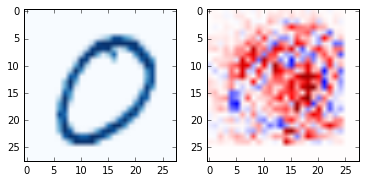

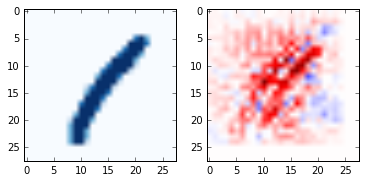

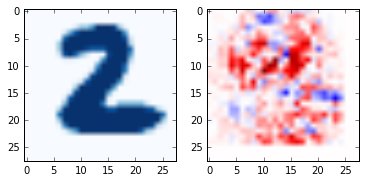

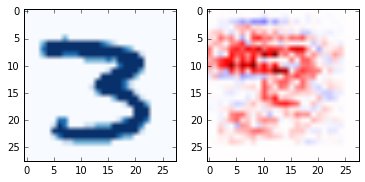

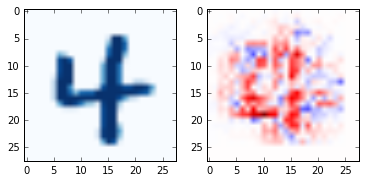

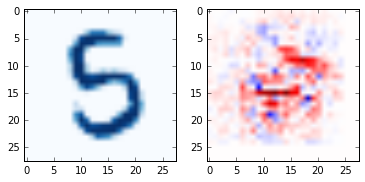

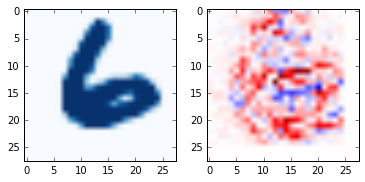

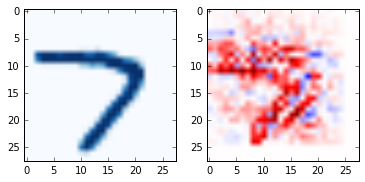

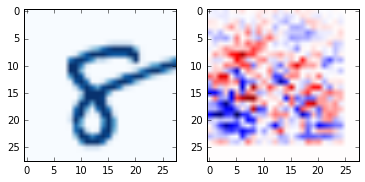

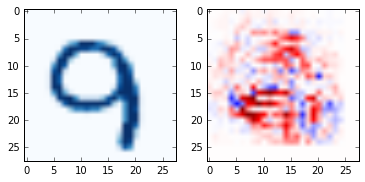

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


for idx in range(10):
    attr = results[idx][1]
    th = max(np.abs(np.min(attr)), np.abs(np.max(np.max(attr))))
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(results[idx][0], cmap='Blues');
    ax[1].imshow(attr, cmap="seismic", vmin=-th, vmax=th);

We can see the shape of each digit. The network looks at pixels around the digit pixels and make predictions. The noise, however, arises all over 0 valued pixels.

To get more clear attributions, we pick a 7 digit picture as a benchmark. 

In [10]:
results = dict()
benchmark_digit = 7
baseline = test_data[benchmark_digit][1]
for idx, test_item in test_data.items():
    X = test_item[1]
    grads, output = integrated_gradients(model, X, output_idx=idx,
                                         baseline=baseline)
    results[idx] = (X[0].numpy(), grads[0])

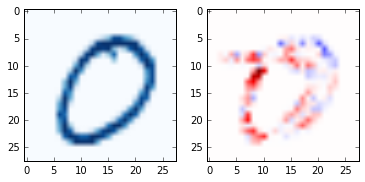

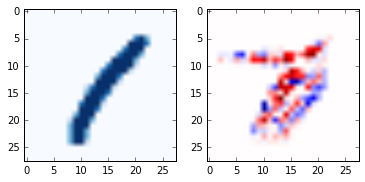

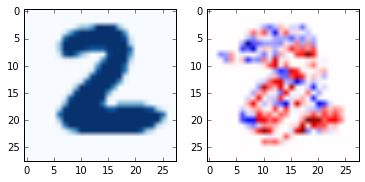

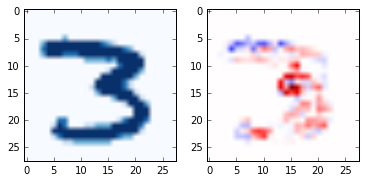

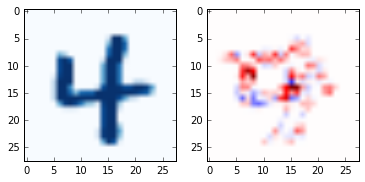

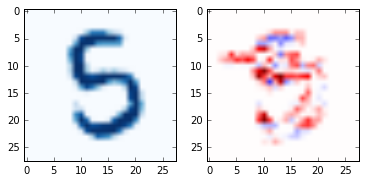

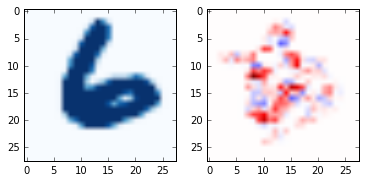

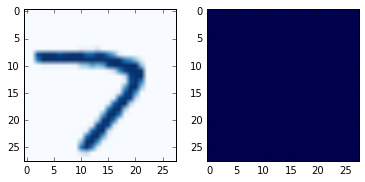

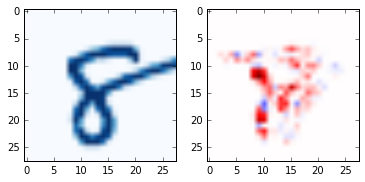

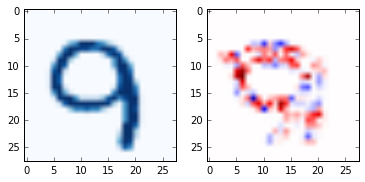

In [11]:
for idx in range(10):
    attr = results[idx][1]
    th = max(np.abs(np.min(attr)), np.abs(np.max(np.max(attr))))
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(results[idx][0], cmap='Blues');
    ax[1].imshow(attr, cmap="seismic", vmin=-th, vmax=th);

In this example, we can see more clear shape of digits. For each attribution, we can see the shape of the predicted digit and benchmark digit 7.

# Wrap Up

`Integrated Gradient` is easy to implement and holds theoretically sound properties. This tool potentially has wider applications. In the future work, I would like consider application to financial markets e.g., what macro factors have an effect on each market regime.


# References
1. [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf)
2. [Keras Implementation](https://github.com/hiranumn/IntegratedGradients)
3. [TensorFlow Implementation](https://github.com/ankurtaly/Integrated-Gradients)